In [1]:
from qiskit import QuantumCircuit, execute, transpile
import numpy as np
from qiskit.providers.aer import Aer
from matplotlib import pyplot as plt
from qiskit.providers.fake_provider import FakeVigoV2

plt.style.use("ggplot")

## The Hamiltonian
$$
H = \cos(\omega t)\sigma^z + \sin(\omega t)\sigma^x
$$
Shrodinger equation:
$$
i\frac{\partial}{\partial t}\ket{0,t} = H\ket{0,t} \Rightarrow \ket{0,t} = \lim_{\Delta t \to 0}\prod_{n=0}^{t/\Delta t} \exp\left(-i\int_{n\Delta t}^{(n+1)\Delta t}dt' H(t') \right)\ket{0}
$$
The trotter formula:
$$
\lim_{n\to \infty} [\exp(\frac{A}{n})\exp(\frac{B}{n})]^n = \exp(A+B)
$$
A single term in the product:
$$
\exp\left(-i\int_{n\Delta t}^{(n+1)\Delta t}dt' H(t') \right) \approx \exp(-i\Delta t H(n\Delta t)\sigma^z) \approx \exp(-i\Delta t \cos(\omega n \Delta t)\sigma^x)\exp(-i\Delta t\sin(\omega n\Delta t)) \approx 
$$
Thus the trotter approximation is
$$
\ket{0,t} \approx \prod_n^{N}r_z(\Delta t \cos(\omega t_n))r_x(\Delta t \sin(\omega t_n))\ket{0}
$$
With $t_n \equiv n\Delta t$ and $N \equiv \frac{t}{\Delta t}$.

In [2]:
backend = FakeVigoV2()

In [1]:
deltat = .5
omega = .1
def trotter(T):
    qc = QuantumCircuit(1)
    N = int(T/deltat)
    for n in range(N):
        qc.rz(2*deltat*np.cos(n*deltat*omega), 0)
        qc.rx(2*deltat*np.sin(n*deltat*omega), 0)
    return qc

In [2]:
res = []
depths = np.linspace(0, 10*np.pi, 30)
for i in depths:
    qc = trotter(i)
    qc.measure_all()
    circ = transpile(qc,backend, optimization_level = 0)
    results  = backend.run(qc, shots = 10000).result().get_counts()
    res.append((results.get('0',0)-results.get('1',0))/sum(results.values()))

NameError: name 'np' is not defined

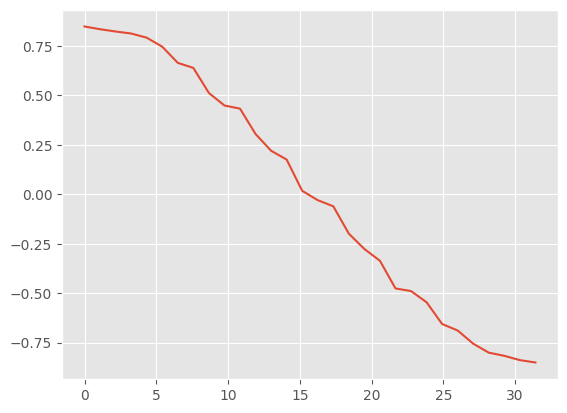

In [390]:
plt.plot(depths, res)

In [375]:
from qutip import sigmax, sigmaz, basis
from qutip.sesolve import sesolve

In [376]:
def cz(t, now):
    omega = now['omega']
    return np.cos(omega*t)

def cx(t, now):
    omega = now['omega']
    return np.sin(omega*t)

In [377]:
H = [[sigmaz(),cz],[sigmax(), cx]]

In [378]:
psi0 = basis(2, 0)

In [362]:
result = sesolve(H, psi0, depths, [sigmaz()], args = {"omega":omega})

In [363]:
result.expect

[array([ 1.        ,  0.99472264,  0.96330185,  0.9511477 ,  0.91790651,
         0.82894274,  0.80902898,  0.73976103,  0.6079425 ,  0.58668817,
         0.47907552,  0.32517684,  0.30494191,  0.1645782 ,  0.01093131,
        -0.00909442, -0.1684233 , -0.30251856, -0.32416664, -0.48237216,
        -0.58414315, -0.60770698, -0.74211695, -0.80691653, -0.82915646,
        -0.91919412, -0.94995215, -0.96346512, -0.9951124 , -0.99999232])]

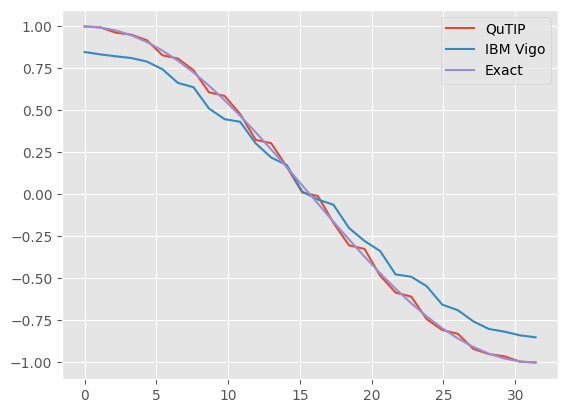

In [392]:
plt.plot(depths, result.expect[0])
plt.plot(depths, res)
plt.plot(depths, [np.cos(omega*d) for d in depths])
plt.legend(["QuTIP", 'IBM Vigo', 'Exact'])

In [365]:
trotter(.1).draw()

q:

In [366]:
from qiskit.providers.aer.noise import phase_amplitude_damping_error, NoiseModel

In [367]:
error = phase_amplitude_damping_error(.005, .005, .1)
noise = NoiseModel()
noise.add_all_qubit_quantum_error(error, ['rx', 'ry', 'rz'])

In [394]:
res = []
depths = np.linspace(0, 10*np.pi, 30)
for i in depths:
    qc = trotter(i)
    qc.measure_all()
    results  = backend.run(qc, shots = 10000, noise_model = noise).result().get_counts()
    res.append((results.get('0',0)-results.get('1',0))/sum(results.values()))

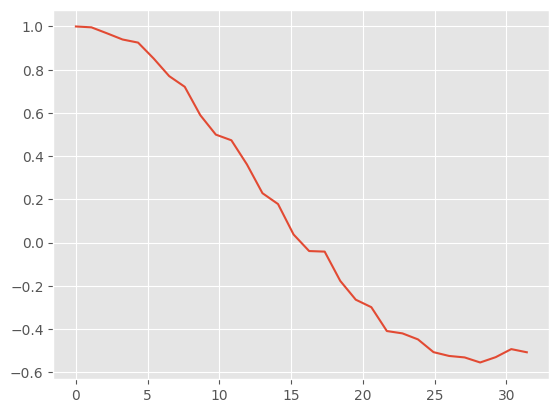

In [369]:
plt.plot(depths, res)

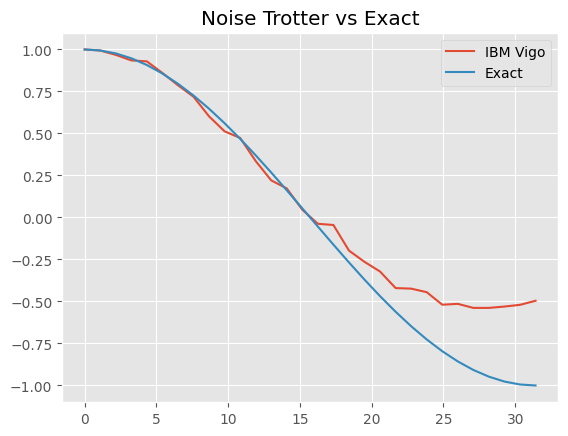

In [395]:
plt.title("Noise Trotter vs Exact")
plt.plot(depths, res)
plt.plot(depths, [np.cos(omega*d) for d in depths])
plt.legend(['IBM Vigo', 'Exact'])